# Python simulation of discrete-time SIR model

Firstly we define the data generation function for the SIR model. Beta and Gamma values are calculated from 2 starting parameters which will be sampled from a uniform prior. The starting parameters can be modelled as follows:

$$
R_0 \sim \text{Uniform}(1.01, 3)
$$

$$
D \sim \text{Uniform}(2, 6)
$$

$$
\gamma = \frac{1}{D}
$$

$$
\beta = R_0 \cdot \gamma
$$



Starting populations for each compartment
 - S = 0.99 * N
 - I = 0.01 * N
 - R = 0


The model can be modelled 4 different ways:

### Deterministic process

$$
\lambda_{\text{infect}} =  \beta \cdot \frac{S \cdot I}{N}
$$

$$
  \lambda_{\text{recoveries}} = \gamma \cdot I
$$


### Stochastic process

$$
  \lambda_{\text{infect}} \sim \text{Binomial}\left(S, \beta \cdot \frac{I}{N} \right)
$$


$$
  \lambda_{\text{recover}} \sim \text{Binomial}\left(I, \gamma \right)
$$

### Deterministic observations

$$
reported = \text{CAR} \cdot \lambda_{\text{infect}}
$$

### Stochastic observations

$$
reported \sim \text{Poisson}\left(\text{CAR} \cdot \lambda_{\text{infect}}\right)
$$

Provided below is the data simulation model where the parameters of interest from a Bayesian perspective would be beta and gamma.
Also defined are the plotting functions for the generated data

In [5]:
# imports

from matplotlib import pyplot as plt
import numpy as np
import torch

# `generate_data` Function

The `generate_data` function simulates epidemic outbreak dynamics using an SIR (Susceptible–Infectious–Recovered) model.  

---

## Parameters

- **N** (`int`, default=300):  
  Total population size.

- **days** (`int`, default=100):  
  Number of days to simulate.

- **batch_size** (`int`, default=100):  
  Number of independent epidemic simulations to generate.

- **process** (`str`, default="d"):  
  Type of epidemic dynamics:  
  - `"d"` → Deterministic updates  
  - `"s"` → Stochastic updates (binomial transitions)

- **observations** (`str`, default="s"):  
  Type of observation model:  
  - `"d"` → Deterministic counts (`floor(new_infections)`)  
  - `"s"` → Stochastic counts (`Poisson`-distributed)

- **beta** (`torch.Tensor` or `None`, default=None):  
  Infection rate parameter. If `None`, sampled from a distribution using `R0` and `gamma`.

- **gamma** (`torch.Tensor` or `None`, default=None):  
  Recovery rate parameter. If `None`, sampled from `1/D`, where `D` is the mean infectious duration.

---

## Returns

A tuple of three tensors:

1. **theta**:  
   - Column 0: Infection rate (`beta`)  
   - Column 1: Recovery rate (`gamma`)

2. **processData**:  
   Simulated SIR states over time:  
   - Index 0: Susceptible population  
   - Index 1: Infected population  
   - Index 2: Recovered population  

3. **caseData**:  
   Observed new infection counts over time.

---

## Model Details

- **Initial conditions**:  
  - 99% of the population susceptible (`S`)  
  - 1% infected (`I`)  
  - 0% recovered (`R`)  

- **Parameter priors**:  
  - Mean infectious period `D ~ Uniform(2, 6)`  
  - Basic reproduction number `R0 ~ Uniform(1.01, 3)`  
  - Recovery rate `gamma = 1/D` (if not specified)  
  - Infection rate `beta = R0 * gamma` (if not specified)  

- **Dynamics**:  
  - **Deterministic**:  
    - `new_infections = beta * S * I / N`  
    - `new_recoveries = gamma * I`  
  - **Stochastic**:  
    - `new_infections ~ Binomial(S, beta * I / N)`  
    - `new_recoveries ~ Binomial(I, gamma)`

- **Observations**:  
  - Deterministic → `floor(new_infections)`  
  - Stochastic → `Poisson(new_infections)`


In [ ]:
def generate_data(N=300, days=100, batch_size=100, process="d", observations="s", beta=None, gamma=None):
    # Initialise tensor of shape (batch_size, 3, days)
    processData = torch.zeros(batch_size, 3, days)
    caseData = torch.zeros(batch_size, 1, days)


    D = torch.distributions.Uniform(low=2, high=6).sample((batch_size,))
    R0 = torch.distributions.Uniform(low=1.01, high=3).sample((batch_size,))

    theta = torch.zeros(batch_size, 2)


    if gamma is not None:
        theta[:, 1] = gamma
    else:
        theta[:, 1] = 1/D
    if beta is not None:
        theta[:, 0] = beta
    else:
        theta[:, 0] = R0 * theta[:, 1]


    # Set initial compartment populations
    processData[:, 0, 0] = 0.99 * N  # S
    processData[:, 1, 0] = 0.01 * N  # I
    processData[:, 2, 0] = 0              # R

    for day in range(days - 1):
        S = processData[:, 0, day]
        I = processData[:, 1, day]
        R = processData[:, 2, day]

        beta = theta[:, 0]
        gamma = theta[:, 1]

        if process[0].lower() == "d":
            new_infections = beta * S * I / N
            new_recoveries = gamma * I
        elif process[0].lower() == "s":
            new_infections = torch.distributions.Binomial(total_count=S, probs=beta * I / N).sample()
            new_recoveries = torch.distributions.Binomial(total_count=I, probs=gamma).sample()
        if observations[0].lower() == "d":
            caseData[:, 0, day] = torch.floor(new_infections)
        elif observations[0].lower() == "s":
            caseData[:, 0, day] = torch.distributions.Poisson(rate=new_infections).sample()


        processData[:, 0, day + 1] = S - new_infections
        processData[:, 1, day + 1] = I + new_infections - new_recoveries
        processData[:, 2, day + 1] = R + new_recoveries

    return theta, processData, caseData

# SIR Model Subplots

The `generate_subplots` function produces a **2×2 grid of epidemic simulations** using the SIR model.  
Each subplot shows the dynamics of **Susceptible (S)**, **Infected (I)**, **Recovered (R)**, and **Observed Cases** over time.  

The four panels compare combinations of:

- **Stochastic vs. Deterministic process dynamics**  
- **Stochastic vs. Deterministic observation models**

This allows visual comparison of how randomness in the process and observation affects epidemic trajectories.


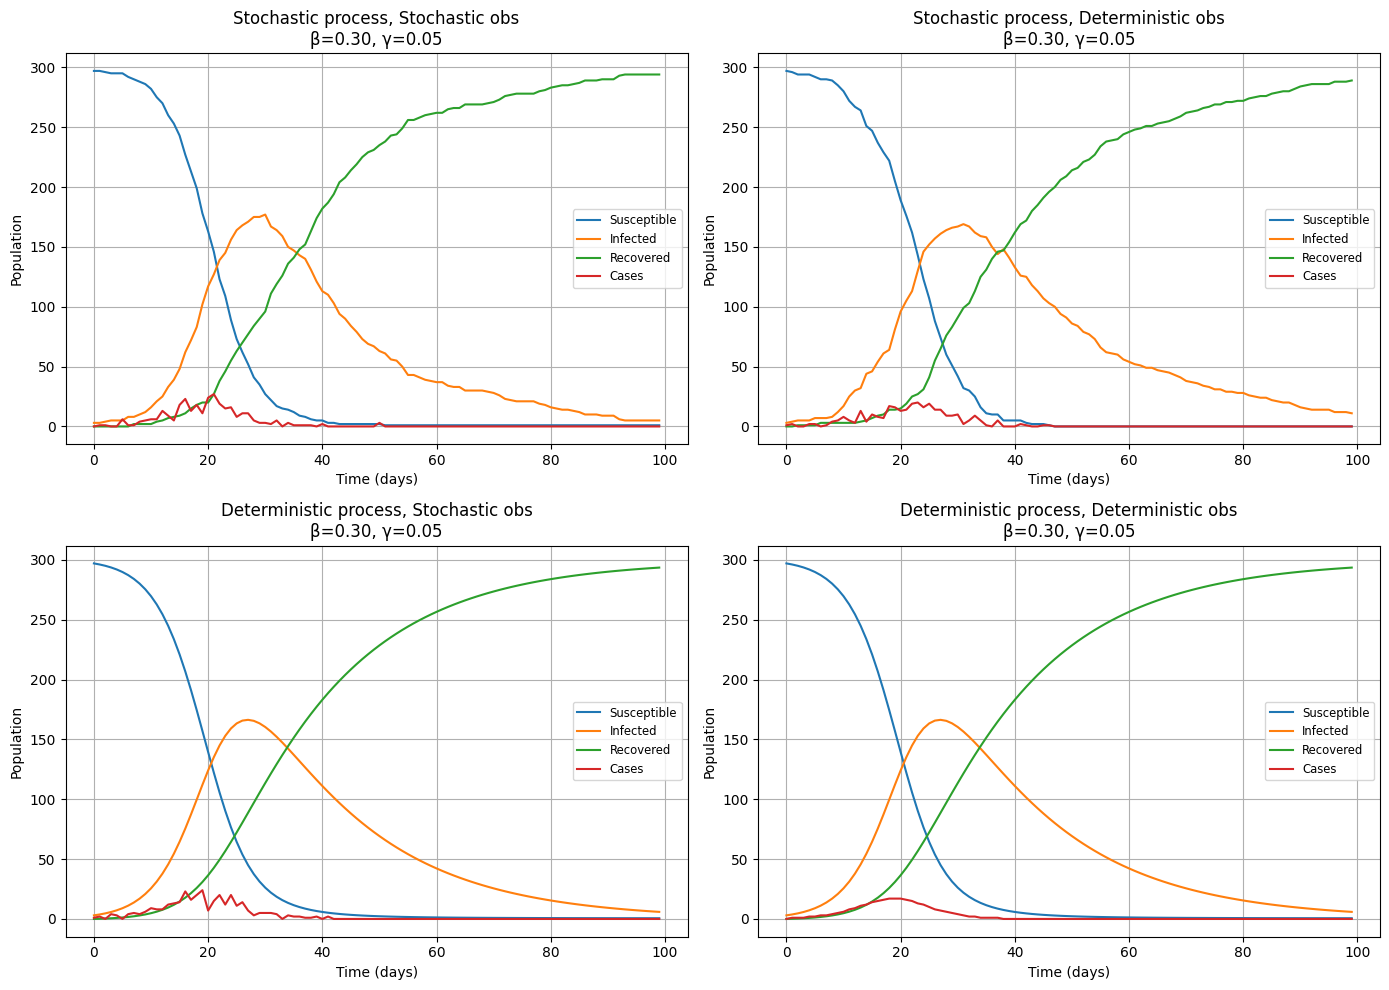

In [4]:
def plot_SIR_subplot(ax, S, I, R, cases, days, beta, gamma, process, observation):
    ax.plot(np.arange(days), S, label='Susceptible')
    ax.plot(np.arange(days), I, label='Infected')
    ax.plot(np.arange(days), R, label='Recovered')
    ax.plot(np.arange(days), cases, label='Cases')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population')
    ax.set_title(f'{process} process, {observation} obs\nβ={beta:.2f}, γ={gamma:.2f}')
    ax.grid()
    ax.legend(fontsize='small')



def generate_subplots(N=300, days=100, beta=None, gamma=None):
    # Generate data
    theta_ss, processData_ss, caseData_ss = generate_data(N=N, days=days, batch_size=1, process="stochastic", observations="stochastic", beta=beta, gamma=gamma)
    theta_sd, processData_sd, caseData_sd = generate_data(N=N, days=days, batch_size=1, process="stochastic", observations="deterministic", beta=beta, gamma=gamma)
    theta_ds, processData_ds, caseData_ds = generate_data(N=N, days=days, batch_size=1, process="deterministic", observations="stochastic", beta=beta, gamma=gamma)
    theta_dd, processData_dd, caseData_dd = generate_data(N=N, days=days, batch_size=1, process="deterministic", observations="deterministic", beta=beta, gamma=gamma)

    # Set up 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    plot_SIR_subplot(axs[0, 0], processData_ss[0, 0].numpy(), processData_ss[0, 1].numpy(), processData_ss[0, 2].numpy(),
                    caseData_ss[0, 0].numpy(), 100, theta_ss[0, 0].item(), theta_ss[0, 1].item(), "Stochastic", "Stochastic")

    plot_SIR_subplot(axs[0, 1], processData_sd[0, 0].numpy(), processData_sd[0, 1].numpy(), processData_sd[0, 2].numpy(),
                    caseData_sd[0, 0].numpy(), 100, theta_sd[0, 0].item(), theta_sd[0, 1].item(), "Stochastic", "Deterministic")

    plot_SIR_subplot(axs[1, 0], processData_ds[0, 0].numpy(), processData_ds[0, 1].numpy(), processData_ds[0, 2].numpy(),
                    caseData_ds[0, 0].numpy(), 100, theta_ds[0, 0].item(), theta_ds[0, 1].item(), "Deterministic", "Stochastic")

    plot_SIR_subplot(axs[1, 1], processData_dd[0, 0].numpy(), processData_dd[0, 1].numpy(), processData_dd[0, 2].numpy(),
                    caseData_dd[0, 0].numpy(), 100, theta_dd[0, 0].item(), theta_dd[0, 1].item(), "Deterministic", "Deterministic")

    plt.tight_layout()
    plt.show()

generate_subplots(N=300, days=100, beta=0.3, gamma=0.05)